In [1]:
import os
import pandas as pd
import glob
from os import walk
import numpy as np
import random

In [2]:
from bisect import bisect_left 
from bisect import bisect_right

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()
import statsmodels.api as sm

# Functions

In [6]:
def Cost_Fun(K,ind,total,lambda_):
    lens = 59
    left = total
    cost = 0
    for i in range(lens):
        curr_data = process_data[ind,i,:]
        mid_pr = curr_data[0]/10000
        quantity = -K[i,0]*mid_pr -K[i,1]*left
        left -= quantity
        qt = np.array([curr_data[2], curr_data[4], curr_data[6], curr_data[8]])
        qt_cum = np.cumsum(qt)
        posi = int(np.min([int(np.sum(qt_cum<=quantity)),4]))
        qt_tr = np.zeros(5)
        qt_tr[:4] = qt*np.array(qt_cum<=quantity).astype(float)
        qt_tr[posi] = np.max([quantity,0])-np.sum(qt_tr)
        pr = np.array([curr_data[1], curr_data[3], curr_data[5], curr_data[7],curr_data[7]-10000])/10000
        cost += -qt_tr.dot(pr) + 200*np.max([-quantity,0]) + lambda_ *(left)**2
    
    curr_data = process_data[ind,-1,:]
    qt = np.array([curr_data[2], curr_data[4], curr_data[6], curr_data[8]])
    qt_cum = np.cumsum(qt)
    posi = int(np.min([int(np.sum(qt_cum<=left)),4]))
    qt_tr = qt*np.array(qt_cum<=quantity).astype(float)
    qt_tr[posi] = np.max([quantity,0])-np.sum(qt_tr)
    pr = np.array([curr_data[1], curr_data[3], curr_data[5], curr_data[7]-10000])/10000
    cost+=  -qt_tr.dot(pr) + 200*np.max([-left,0]) + lambda_ *(left)**2
    
    return cost/total

In [7]:
def inventory_visualizaton(K,pri,total):
    mid_pr = pri/10000
    inventory = np.zeros(61)
    inventory[0] = total
    for t in range(59):
        quantity = -K[t,0]*mid_pr[t] - K[t,1]*inventory[t]
        inventory[t+1] = inventory[t]- quantity
    return inventory

# Data Input

In [8]:
data = pd.read_csv('IBM2018_10-11AM_1MIN.csv')

In [9]:
trading_lens = 60 # trading period
total_dates = 251 # trading day in 2018

In [10]:
# first column: different dates over
# one-minute time bin during 10:00am-11:am
# last column: mid-price; (ask price on level i, ask size on level i) i=1,2,3,4
process_data = np.array(data['0']).reshape((251,60,9))

In [11]:
process_data[0,0,:]

array([1.54665e+06, 1.54610e+06, 2.00000e+02, 1.54580e+06, 1.00000e+02,
       1.54570e+06, 1.01000e+02, 1.54550e+06, 1.00000e+02])

# Initialization 

In [14]:
# coefficients
N = 50
T = 60
#K0 = -0.05*np.ones((T, 2)) #initial policy K_0
#K0[:,:2] *=0.001
K0 = np.ones((60,2))
K0[:,0] *=-0.01
K0[:,1] *=-0.1
r = 0.4#smoothing parameter
D = 2 #dimension
m = 50 #number of trajectories
nsample_mf = 1
eta_mf = 10**-4
CK_mf = np.zeros((N,nsample_mf)) #cost history of the model-free framework
np.random.seed(125)
shares= 5000
K_store = np.ones((N,60,2))
lambda_ = 0.01

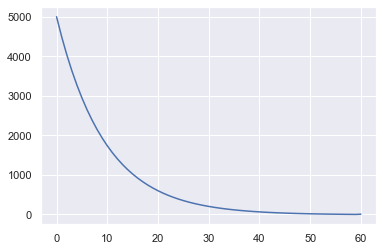

In [15]:
plt.plot(inventory_visualizaton(K0,process_data[3,:,0],shares))

In [16]:
for k in range(nsample_mf):
    K = np.matrix(K0) #current policy
    for i in range(N):
        print(i)
        
        
        nablaCK_hat = np.matrix(np.zeros((T, 2)))
        for j in range(m):
            
            ind  = random.randint(0, 250)
            for j in range(250):
                CK_mf[i,k] += Cost_Fun(K,j,shares,lambda_)
            CK_mf[i,k]/= 250
            
            for t in range(T):
                a = np.random.uniform(low=-0.1, high=0.1,size=(1,1))[0,0]
                b = np.random.uniform(low=-1, high=1,size=(1,1))[0,0]
                Uti = np.matrix(np.array([a,b]))
                Uti = r*Uti/np.linalg.norm(Uti,'fro')
                pertK = np.matrix(K) #perturbed policy K
                pertK[t,:] = pertK[t,:] + Uti
                #print("==")
                #print(Uti)
                #print(pertK[t,:] + Uti)
                #print(pertK)
                ind  = random.randint(0, 250)
                CK_sig = Cost_Fun(pertK,ind,shares,lambda_)
                nablaCK_hat[t,:] = nablaCK_hat[t,:] + (D/r**2)*CK_sig*Uti
        nablaCK_hat = nablaCK_hat/m
        K = K-eta_mf*nablaCK_hat
        print(np.sum(np.abs(eta_mf*nablaCK_hat)),np.sum(np.abs(K)))
        K_store[i,:] = K

0
0.7205052795432119 7.167689203311449
1
0.33519821719150333 7.39564631104269
2
0.3773830680029541 7.57321119466996
3
0.4370111038943225 7.729466266816052
4
0.4229539988568515 7.81125766317091
5
0.46126522216799704 7.869353422741616
6
0.4760774871107873 7.913652909820025
7
0.45216496036958975 7.915946356145673
8
0.44039939206297696 7.944190089390601
9
0.5220291731506399 8.08035125006404
10
0.4736409789460871 8.129031989791148
11
0.5157044445090484 8.268036724276623
12
0.5188960721492595 8.291080858557248
13
0.5429823308727533 8.334728518775858
14
0.5540214951481623 8.369420524431384
15
0.5376817370991762 8.405195071085917
16
0.5521438277650895 8.505517551885886
17
0.5218149389118188 8.383555803083699
18
0.519011313597151 8.379244844076709
19
0.6737136054311017 8.467938800422836
20
0.5745030766894754 8.436107110231916
21
0.5370642954471501 8.461708207343628
22
0.6596773412144987 8.469452116383582
23
0.5605130394829677 8.446550642369058
24
0.6977911285379056 8.49523520599957
25
0.5821077

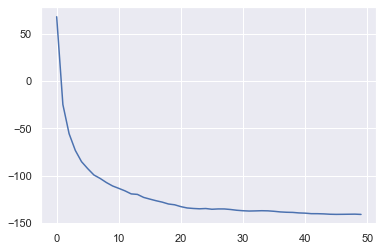

In [17]:
plt.plot(CK_mf)

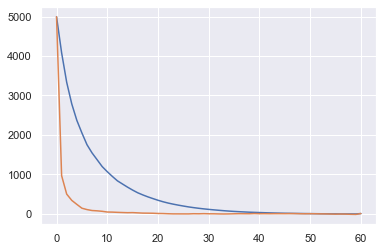

In [18]:
plt.plot(inventory_visualizaton(K_store[0,:],process_data[3,:,0],5000))
plt.plot(inventory_visualizaton(K_store[-1,:],process_data[3,:,0],5000))